# 2018 Data Science Bowl
## Find the nuclei in divergent images to advance medical discovery
* https://www.kaggle.com/c/data-science-bowl-2018
* Step 1. load and preprocess the data
* Step 2. visualization to to plan normalization scheme
* Step 3. normalization of the data
* Step 4. train data generator and data augmentation
* Step 5. build and train a simple CNN
* Step 6. build and train Unet CNN
* Step 7.  Unet model on the test data
* Step 8. apply and compare Simple CNN with Unet results
* source: https://www.kaggle.com/kmader/nuclei-overview-to-submission

In this project, I investigate the potential 2D U-net to segment the nuclei in divergent images. Deep learning U-net neural network, has proven lately as efficient tool for many biomedical segmentation tasks. The nature of most medical images, that have high correlation among near voxel, make them good candidate for analyzing with convolution sliding window.


In [1]:
import numpy as np 
import pandas as pd 
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

In [2]:
# Import necessary modules and set global constants and variables. 

import tensorflow as tf                                             
import cv2                         # To read and manipulate images
import sys                         # System-specific parameters and functions
import tqdm                        # Use smart progress meter
import matplotlib.pyplot as plt    # Python 2D plotting library
import matplotlib.cm as cm         # Color map           

# Global constants.
IMG_CHANNELS = 3      # Default number of channels
CW_DIR = '/media/naomi/Data/afeka/' #os.getcwd() 
TRAIN_DIR = os.path.join(os.path.dirname(CW_DIR), 'kaggle', 'input', 'stage1_train')
IMG_DIR_NAME = 'images'   # Folder name including the image
MASK_DIR_NAME = 'masks'   # Folder name including the masks
SEED = 100                # Random seed for splitting train/validation sets

x_train = []
y_train = []

## Step 1. Load the data

In [57]:

def read_image(filepath): 
    """Read an image from a file and resize it."""
    img = cv2.imread(filepath)
    return img

def read_mask(directory):
    """Read and resize masks contained in a given directory."""
    for i,filename in enumerate(next(os.walk(directory))[2]):
        mask_path = os.path.join(directory, filename)
        mask_tmp = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if not i: mask = mask_tmp
        else: mask = np.maximum(mask, mask_tmp)
    return mask 

In [58]:
# Collection of methods for data operations. Implemented are functions to read  
# images/masks from files and to read basic properties of the train/test data sets.


def read_train_data_properties(train_dir, img_dir_name, mask_dir_name):
    """Read basic properties of training images and masks"""
    tmp = []
    for i,dir_name in enumerate(next(os.walk(train_dir))[1]):

        img_dir = os.path.join(train_dir, dir_name, img_dir_name)
        mask_dir = os.path.join(train_dir, dir_name, mask_dir_name) 
        num_masks = len(next(os.walk(mask_dir))[2])
        img_name = next(os.walk(img_dir))[2][0]
        img_name_id = os.path.splitext(img_name)[0]
        img_path = os.path.join(img_dir, img_name)
        img_shape = read_image(img_path).shape
        tmp.append(['{}'.format(img_name_id), img_shape[0], img_shape[1],
                    img_shape[0]/img_shape[1], img_shape[2], num_masks,
                    img_path, mask_dir])

    train_df = pd.DataFrame(tmp, columns = ['img_id', 'img_height', 'img_width',
                                            'img_ratio', 'num_channels', 
                                            'num_masks', 'image_path', 'mask_dir'])
    return train_df

In [59]:
# Basic properties of images/masks. 
train_df = read_train_data_properties(TRAIN_DIR, IMG_DIR_NAME, MASK_DIR_NAME)

print('train_df:')
print(train_df.describe())

train_df:
        img_height    img_width   img_ratio  num_channels   num_masks
count   670.000000   670.000000  670.000000         670.0  670.000000
mean    333.991045   378.500000    0.658209           3.0   43.971642
std     149.474845   204.838693    0.474664           0.0   47.962530
min     256.000000   256.000000    0.000000           3.0    1.000000
25%     256.000000   256.000000    0.000000           3.0   15.250000
50%     256.000000   320.000000    1.000000           3.0   27.000000
75%     360.000000   360.000000    1.000000           3.0   54.000000
max    1040.000000  1388.000000    1.000000           3.0  375.000000


We can see that all images has 3 channles, also images differ in sizes

In [60]:
def load_raw_data():
    """Load raw data."""
    # Python lists to store the training images/masks and test images.
    x_train, y_train = [],[]
    
    # Read  train images/masks. 
    print('Loading train images and masks ...')
    sys.stdout.flush()
    for i, filename in tqdm.tqdm(enumerate(train_df['image_path']), total=len(train_df)):
        img = np.array(read_image(train_df['image_path'].loc[i]), np.float32)
        mask = np.array(read_mask(train_df['mask_dir'].loc[i]))
        x_train.append(img)
        y_train.append(mask)
    
    return x_train, y_train   

In [61]:
# Read images/masks from files
# is stored as list of a 3-dim array where the number of channels is 3 for images 1 for masks
x_train, y_train = load_raw_data()

Loading train images and masks ...


100%|██████████| 670/670 [00:38<00:00, 17.58it/s]


## Step 2. Data visualization
Here we show a few images of the cells where we see there is a mixture of brightfield and fluorescence which will probably make using a single segmentation algorithm difficult


In [62]:
print(x_train[80].min(), x_train[80].max(), x_train[80].shape)
print(y_train[80].min(), y_train[80].max(), y_train[80].shape)

(0.0, 216.0, (256, 320, 3))
(0, 255, (256, 320))


In [314]:
def show_img_inline(im=x_train, labels=None):
    
    fig, axs = plt.subplots(1, len(im), figsize=(len(im)*4,4))
    for i in range(len(im)):
            
            axs[i].imshow(im[i]/im[i].max())
            if (labels is not None):
                axs[i].set_title(labels[i])
            axs[i].axis('off')

In [266]:
def show_img_grid(row=2, col=4, im=x_train):
    
    fig, axs = plt.subplots(row,col,figsize=(col*3,row*3))
    for i in range(row):
        for j in range(col):
            n = np.random.randint(0,len(im))
            axs[i,j].imshow(im[n]/im[n].max())
            axs[i,j].axis('off')

In [267]:
def show_img_mask_grid(row=2, col=4, im=x_train, msk=y_train, label_msk = 'mask'):
    
    fig, axs = plt.subplots(row,col,figsize=(col*3,row*3))
    for i in range(row):
        for j in range(col//2):
            n = np.random.randint(0,len(im))
            axs[i,j*2].imshow(im[n]/im[n].max())
            axs[i,j*2].set_title('{}. image'.format(n))
            axs[i,j*2].axis('off')
            axs[i,j*2+1].imshow(msk[n])
            axs[i,j*2+1].set_title('{}. {}'.format(n, label_msk))
            axs[i,j*2+1].axis('off')

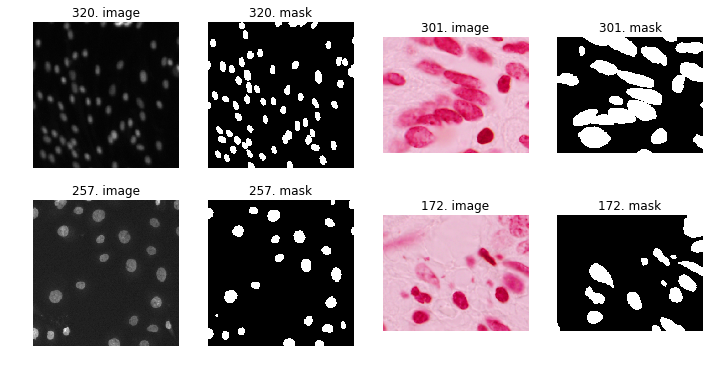

In [13]:
show_img_mask_grid()

## Step 3. Normalize
We can see that images differ in intenity scale. To normalize, we will invert the bright images, and normalize all to [0,1]

In [63]:
def normalize(x):
    for i in range(x.shape[2]):
        div = np.max(x[:,:,i]) 
        if (div < 0.01*x[:,:,i].mean()): div = 1. # protect against too small pixel intensities
        x[:,:,i] = x[:,:,i].astype(np.float32)/div
    return x

In [64]:

def invert(x, cutoff=0.5):
    
    print(x.min(), x.max(), x.mean())
    if (np.mean(x)>cutoff):
        x = 1. - x
    return x

def preprocess_image(im, cutoff=0.5):
    im = normalize(im)
    if (np.mean(im)>cutoff):
        im = 1. - im
        im = normalize(im)
    return im 
                           

In [65]:
def preprocess_images(images, cutoff=0.5):
    ret_im = []
    for im in images:
        im = preprocess_image(im, cutoff=0.5)
        ret_im.append(im)
    return ret_im 


In [66]:
def preprocess_masks(masks):
    ret_msk = []
    
    for m in masks:
        if (m.max() != 255): print(m.max())
        m = m/255
        ret_msk.append(m)
    return ret_msk 

In [67]:
y_train = preprocess_masks(y_train)
x_train_norm = preprocess_images(x_train)

Lets view some normalized images and masks

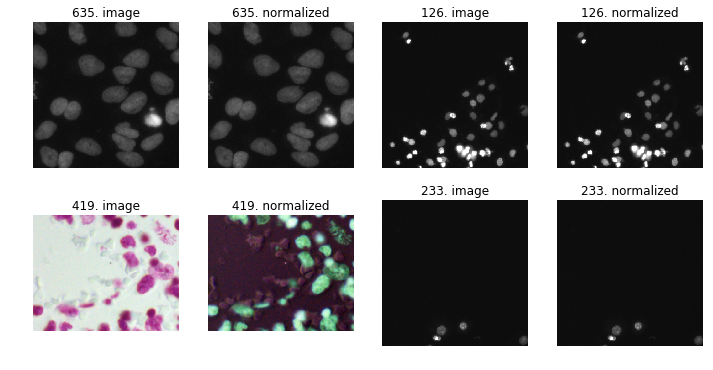

In [68]:
show_img_mask_grid(row=2, col=4, im=x_train, msk=x_train_norm, label_msk = 'normalized')

In [69]:
x_train = x_train_norm

## Step 4. train data generator and data augmentation

### Check Dimensions 
Here we show the dimensions of the data to see the variety in the input images

In [70]:
train_df['shapes'] = train_df.apply(lambda row: np.array(read_image(row['image_path'])).shape, axis=1)

In [71]:
train_df['shapes'].value_counts()

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: shapes, dtype: int64

### Data augmentation
The simple  CNN will be for any gien size. We will train it with 256x256 croped images, and we apply it to predict any image size.

In [72]:
def data_aug(image,label):
    
    if (np.random.randint(0, 2)):
        return image, label

    if (np.random.randint(0, 2)):
        
        image = np.rot90(image)
        label = np.rot90(label)
        return image, label
    
    if (np.random.randint(0, 2)):

        image = np.flipud(image)
        label = np.flipud(label)

    return image, label

In [86]:
def data_cut(image, lable, lsize=256):
    
    img = np.zeros((lsize, lsize, IMG_CHANNELS))
    msk = np.zeros((lsize, lsize, 1))

    i = 0
    j = 0
    w = image.shape[0] - lsize
    h = image.shape[1] - lsize
    
    if (w > 0):
        i = np.random.randint(0, w)
    if (h > 0):
        j = np.random.randint(0, h)
    img = image[i:i+256, j:j+256, :]
    msk = lable[i:i+256, j:j+256]
    
    return img, msk 

### Split the data to Test and Train

In [227]:
from sklearn.model_selection import train_test_split
x_trn, x_vld, y_trn, y_vld = train_test_split( x_train, y_train, test_size=0.1, random_state=42)

### Generate train and validation data
The generator will generate batches which are numpy arrays of size 256x256. For train data we will use augmentation, and for validation data only crop.

In [229]:
IMG_WIDTH=256
def valid_data_gen(X, Y):

    x = np.zeros((len(X), IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS))
    y = np.zeros((len(X), IMG_WIDTH, IMG_WIDTH,1))

    for i in range(len(X)):
            img, msk = X[i], Y[i]
            img, msk = data_cut(img, msk)
            x[i] = img
            y[i] = np.expand_dims(msk, -1)

    return x,y


In [112]:
IMG_WIDTH=256
def data_gen(X, Y, batch_size = 10):

    x = np.zeros((batch_size, IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS))
    y = np.zeros((batch_size, IMG_WIDTH, IMG_WIDTH,1))

    while True:
        indx = np.random.randint(0,len(X),batch_size)
        k = 0
        for i in indx:
            
            img, msk = data_aug(X[i], Y[i])
            img, msk = data_cut(img, msk)
            x[k] = img
            y[k] = np.expand_dims(msk, -1)
            k+=1
        yield x,y



In [126]:
train_gen = data_gen(x_trn,  y_trn)
x,y = train_gen.next()


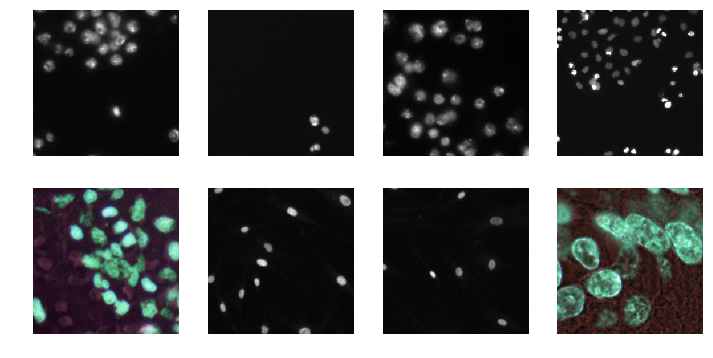

In [125]:
show_img_grid(row=2, col=4, im=x)

In [36]:
print(len(x_vld))

67


In [232]:
valid_gen = data_gen(x_vld,  y_vld, batch_size = len(x_vld))
x_valid,y_valid = valid_gen.next()
print(x_valid.shape, y_valid.shape)

((67, 256, 256, 3), (67, 256, 256, 1))


In [127]:
x_valid,y_valid = valid_data_gen(x_vld,  y_vld)

## Step 5. Build a simple CNN
Here we make a very simple CNN just for a benchmark. For this we use a batch normalization to normalize the inputs. We cheat a bit with the padding to keep problems simple.

In [318]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape = (None, None, IMG_CHANNELS), 
                                  name = 'NormalizeInput'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
# use dilations to get a slightly larger field of view
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

# the final processing
simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))

In [319]:
simple_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d_60 (Conv2D)           (None, None, None, 8)     224       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, None, None, 8)     584       
_________________________________________________________________
conv2d_62 (Conv2D)           (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_63 (Conv2D)           (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_64 (Conv2D)           (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_65 (Conv2D)           (None, None, None, 16)    528       
__________

# Loss
Since we are being evaulated with intersection over union we can use the inverse of the DICE score as the loss function to optimize

In [320]:
from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [321]:
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


In [322]:
from keras.optimizers import Adam
learning_rate=0.001
simple_cnn.compile(optimizer=Adam(lr=learning_rate),
                           loss = dice_coef_loss, 
                   metrics = ['binary_crossentropy', jaccard_distance_loss])

# Simple Training
Here we run a simple training, with each image being it's own batch (not a very good idea), but it keeps the code simple

In [323]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

history = simple_cnn.fit_generator(train_gen, steps_per_epoch=len(x_train)//10,
                        validation_data = (x_valid, y_valid), epochs = 10,
                                  callbacks=[early_stopping])

Epoch 1/10
67/67 [==============================] - 112s 2s/step - loss: -0.6692 - binary_crossentropy: 0.9879 - jaccard_distance_loss: 0.1252 - val_loss: -0.7535 - val_binary_crossentropy: 0.3027 - val_jaccard_distance_loss: 0.0539
Epoch 2/10
67/67 [==============================] - 116s 2s/step - loss: -0.7454 - binary_crossentropy: 0.7289 - jaccard_distance_loss: 0.0745 - val_loss: -0.8475 - val_binary_crossentropy: 0.3902 - val_jaccard_distance_loss: 0.0414
Epoch 3/10
67/67 [==============================] - 123s 2s/step - loss: -0.8095 - binary_crossentropy: 0.6379 - jaccard_distance_loss: 0.0555 - val_loss: -0.8494 - val_binary_crossentropy: 0.4242 - val_jaccard_distance_loss: 0.0408
Epoch 4/10
67/67 [==============================] - 121s 2s/step - loss: -0.7963 - binary_crossentropy: 0.7000 - jaccard_distance_loss: 0.0577 - val_loss: -0.8500 - val_binary_crossentropy: 0.4534 - val_jaccard_distance_loss: 0.0407
Epoch 5/10
67/67 [==============================] - 120s 2s/step - l

In [107]:
def plot_history(history, key='jaccard_distance_loss'):
    # Get training and test loss histories
    training_loss = history.history[key]
    test_loss = history.history['val_{}'.format(key)]

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('model '+ key)
    plt.show();

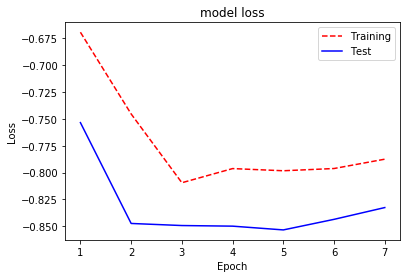

In [324]:
plot_history(history, 'loss')

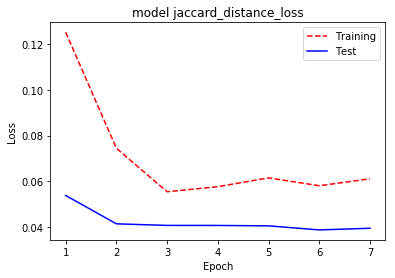

In [325]:
plot_history(history, key='jaccard_distance_loss')

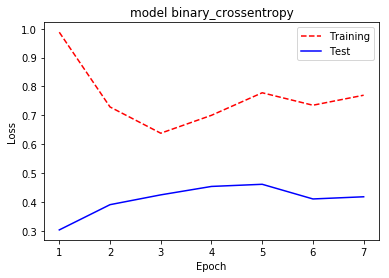

In [326]:
plot_history(history, key='binary_crossentropy')

## Unet
### U-Net: Convolutional Networks
U-Net is a very popular end-to-end encoder-decoder network for semantic segmentation [7]. It's was originally invented and first used for biomedical image segmentation. U-net’s have multi channel architecture, which suits well the nuclei in divergent images.<br>
Medical MRI images feature a high similarity and correlation in the intensities among neighboring voxels, so they are good candidates for the convolution blocks constructing the U-net.<br>
### Model Architecture
 The architecture we used, had 3 channels for the input, and 1 channels in the output. We used a 2D architecture.
 
### U-Net: Model Architecture
U-Net is a very popular end-to-end encoder-decoder network for semantic segmentation. It was originally invented and first used for biomedical image segmentation. U-net’s have multi channel architecture, which suits well the multi channel input of MRI images and the multi-class classification task.<br>
Medical images feature a high similarity and correlation in the intensities among neighboring voxels, so they are good candidates for the convolution blocks constructing the U-net.<br>
Essentially, U-net is a deep-learning framework based on fully convolutional networks, it comprises two parts:<br>
A contracting path similar to an encoder, to capture context from a compact feature representation.<br>
A symmetric expanding path similar to a decoder, which allows accurate  localisation. This step is done to retain boundary information (spatial information) despite down sampling and max-pooling performed in the encoder stage.<br>
Instead of up-sampling methods,in U-net, we concatenate the suitable transformed layer from the decoder path.<br>
** image**

In [233]:
from keras import backend as K
from keras.layers import Input, MaxPooling2D, UpSampling2D, Conv2D, Conv2DTranspose
from keras.layers import concatenate
from keras.models import Model
from keras.optimizers import Adam
def get_unet(IMG_HEIGHT=None, IMG_WIDTH=None, IMG_CHANNELS=3, n_ch_output=1):
    # Build U-Net model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    
    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(n_ch_output, (1, 1), activation='sigmoid', padding='same') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [234]:
from keras.optimizers import Adam
unet = get_unet()
learning_rate=0.001
unet.compile(optimizer=Adam(lr=learning_rate),
                           loss = dice_coef_loss, 
                   metrics = ['binary_crossentropy', jaccard_distance_loss])

In [235]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

history_unet = unet.fit_generator(train_gen, steps_per_epoch=len(x_train)//10,
                        validation_data = (x_valid, y_valid), epochs = 10,
                                  callbacks=[early_stopping])

Epoch 1/10
67/67 [==============================] - 119s 2s/step - loss: -0.3817 - binary_crossentropy: 0.8570 - jaccard_distance_loss: 0.3690 - val_loss: -0.7533 - val_binary_crossentropy: 0.4216 - val_jaccard_distance_loss: 0.0642
Epoch 2/10
67/67 [==============================] - 128s 2s/step - loss: -0.7349 - binary_crossentropy: 0.6438 - jaccard_distance_loss: 0.0721 - val_loss: -0.8212 - val_binary_crossentropy: 0.3521 - val_jaccard_distance_loss: 0.0458
Epoch 3/10
67/67 [==============================] - 123s 2s/step - loss: -0.7620 - binary_crossentropy: 0.7250 - jaccard_distance_loss: 0.0709 - val_loss: -0.7953 - val_binary_crossentropy: 0.5909 - val_jaccard_distance_loss: 0.0577
Epoch 4/10
67/67 [==============================] - 126s 2s/step - loss: -0.7283 - binary_crossentropy: 0.8482 - jaccard_distance_loss: 0.0832 - val_loss: -0.8325 - val_binary_crossentropy: 0.3186 - val_jaccard_distance_loss: 0.0442
Epoch 5/10
67/67 [==============================] - 132s 2s/step - l

In [327]:
unet.save_weights('unet_first10epoch_dc_0.8867.hdf5')

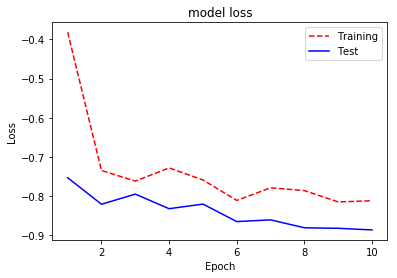

In [239]:
plot_history(history_unet, 'loss')

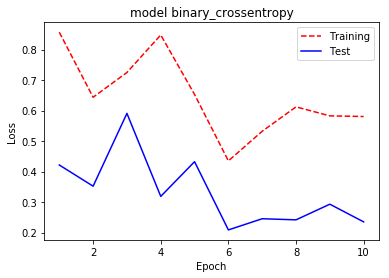

In [240]:
plot_history(history_unet, 'binary_crossentropy')

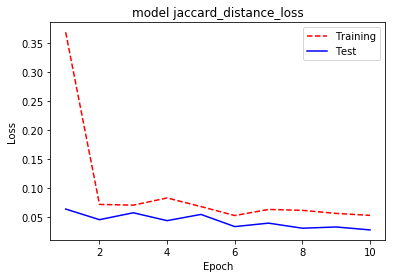

In [242]:
plot_history(history_unet, 'jaccard_distance_loss')

In [334]:
from keras.callbacks import ModelCheckpoint
unet = get_unet()
learning_rate=0.001
unet.compile(optimizer=Adam(lr=learning_rate),
                           loss = jaccard_distance_loss,#, 
                   metrics = ['binary_crossentropy', dice_coef_loss])

In [335]:

unet.load_weights('unet_first10epoch_dc_0.8867.hdf5')

In [336]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)
checkpointer = ModelCheckpoint(filepath = 'model_unet.{epoch:02d}-{val_loss:.6f}.hdf5',verbose=1,
                               save_best_only=True, save_weights_only = True)

history_unet2 = unet.fit_generator(train_gen, steps_per_epoch=len(x_train)//10,
                        validation_data = (x_valid, y_valid), epochs = 2,
                                  callbacks=[early_stopping, checkpointer])

Epoch 1/2
67/67 [==============================] - 125s 2s/step - loss: 0.0498 - binary_crossentropy: 0.5469 - dice_coef_loss: -0.8069 - val_loss: 0.0293 - val_binary_crossentropy: 0.2758 - val_dice_coef_loss: -0.8743

Epoch 00001: val_loss improved from inf to 0.02930, saving model to model_unet.01-0.029303.hdf5
Epoch 2/2
67/67 [==============================] - 130s 2s/step - loss: 0.0544 - binary_crossentropy: 0.6017 - dice_coef_loss: -0.8101 - val_loss: 0.0267 - val_binary_crossentropy: 0.2244 - val_dice_coef_loss: -0.8905

Epoch 00002: val_loss improved from 0.02930 to 0.02673, saving model to model_unet.02-0.026732.hdf5


## Step 8. apply and compare Simple CNN with Unet results

### Build validation data for predicting
U-net architecrure, requires that image and label sizes will be devided by 128. we pad the images and masks with reflection, to the nearest size which is devidable by 128.

In [243]:
def unet_predict_data_gen(X, Y):

    x=[]
    y=[]
    for img,msk in zip(X,Y):
            # get the closest shape that is devided by 128
            
            vwidth = img.shape[0]
            if (vwidth%128 != 0):
                vwidth = int( (128) * (round( vwidth / 128. )))
                if (vwidth < img.shape[0]):
                    vwidth+=128
            vhight = img.shape[1]
            if (vhight%128 != 0):
                vhight = int( (128) * (round( vhight / 128. )))
                if (vhight < img.shape[1]):
                    vhight+=128
        
            img = cv2.copyMakeBorder( img, 
                                     vwidth-img.shape[0], vhight-img.shape[1], 
                                     vhight-img.shape[1], vwidth-img.shape[0],
                                     borderType=cv2.BORDER_REFLECT)

            
            x.append(img)
            msk = cv2.copyMakeBorder( msk, 
                                     vwidth-msk.shape[0], vhight-msk.shape[1], 
                                     vhight-msk.shape[1], vwidth-msk.shape[0],
                                     borderType=cv2.BORDER_REFLECT)

            y.append(np.expand_dims(msk, -1))
        return x,y

In [246]:
x_for_pred, y_for_pred = unet_data_gen(x_vld, y_vld)

View few validation images and masks

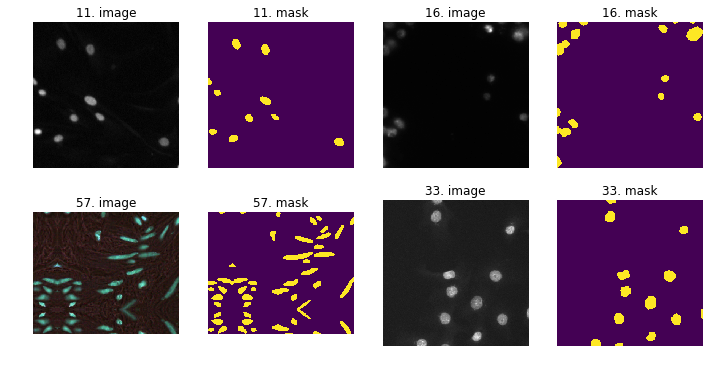

In [249]:
show_img_mask_grid(row=2, col=4, im=x_for_pred, 
                   msk=[y.reshape(y.shape[0], y.shape[1]) for y in y_for_pred])

In [312]:
y_test_pred_proba_cnn = simple_cnn.predict_proba(np.array(x_for_pred[0:2]))

In [257]:
y_test_pred_proba_unet = unet.predict(np.array(x_for_pred[0:2]))

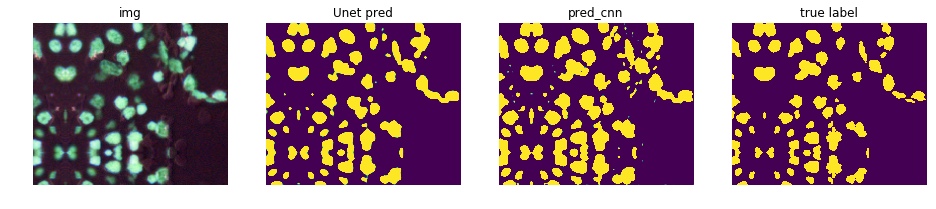

In [315]:
show_img_inline([x_for_pred[0], y_test_pred_proba_unet[0,:,:,0], 
                 y_test_pred_proba_cnn[0,:,:,0],
                 y_for_pred[0][:,:,0]],
                labels=['img', 'Unet pred', 
                        'pred_cnn','true label'])

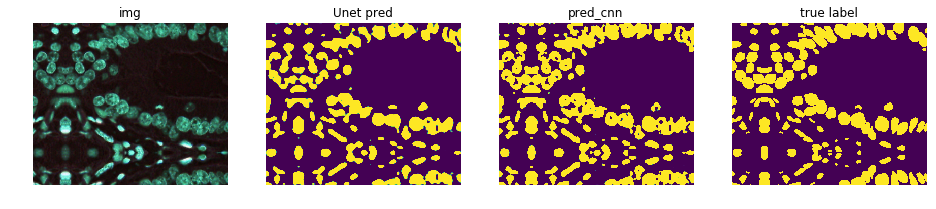

In [316]:
show_img_inline([x_for_pred[1], y_test_pred_proba_unet[1,:,:,0], 
                 y_test_pred_proba_cnn[1,:,:,0],
                 y_for_pred[1][:,:,0]],
                labels=['img', 'Unet pred', 
                        'pred_cnn','true label'])

## Results
The performance of U-net’s was mixed for this segmentation task. 
* The U-net perform well, when segmentation had “blobe” structure, rather then sparse structure.

* The U-net did not separate well between label 4 and 1, and had bad performance on sparse pixel segmentation.

> Simple CNN results: loss: -0.7876 - binary_crossentropy: 0.7696 - jaccard_distance_loss: 0.0611 - val_loss: -0.8327 - val_binary_crossentropy: 0.4176 - val_jaccard_distance_loss: 0.0395

> Unet resolts: loss: -0.8122 - binary_crossentropy: 0.5806 - jaccard_distance_loss: 0.0533 - val_loss: -0.8867 - val_binary_crossentropy: 0.2350 - val_jaccard_distance_loss: 0.0282

# Discussion
U-nets model yield good result in segmenting nuclei in divergent images. To improve the model, I suggest to explore following paths:  
* Preprocessing the data 
Images in data set, are highly variant in sizes and color range, specific equalization technicks, that are suitable to medical imaging should be explored.
* Resampling techniques
In resanpling tecniques the meaning is how we design the train image generator.
* Optional loss functions
The most popular measure in segmentation is IOU. IOU is not defrentable, so it can not be used in backpropogation. Dice Coefficient, is design to give close results to IOU. 
* Data augmentation
Data augmentation, improve results signicantly. The data in this project is highly suitable for augmentation, since to begin with, there is no meanning to orientation and resizing.
* Network architecture
The U-net was not sensitive enough, different architectures, that encodes to smaller size can improve the sensitivity of the segmentation.
* Training parameters
Parameters as batch size, learning rate, optimizers, should be explored with better hardware then I have.<br>

Most promising direction, is a combination of Unet with LSTM that will "sweep" the image to keep track on the location of the specific nucli.

## Articles:
* Abdel Aziz, Allan Hanbury. **Metrics for evaluating 3D medical image segmentation: analysis, selection, and tool**. BMC Med Imaging. 2015; 15: 29. 
* Ilya E Vorontsov†, Ivan V Kulakovskiy, Vsevolod J Makeev. **Jaccard index based similarity measure to compare transcription factor binding site models**. Algorithms for Molecular Biology Sep 2013.
* 1L.-C. Chen, G. Papandreou, I. Kokkinos, K. Murphy, and A. L.Yuille. **Semantic image segmentation with deep convolutional nets and fully connected crfs.** In ICLR, 2015.
* Havaei, M. et. al, Brain Tumor Segmentation with Deep Neural Networks. arXiv preprint arXiv:1505.03540, 2015.Author, F., Author, S., Author, T.: Book title. 2nd edn. Publisher, Location (1999).
* Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-Net: **Convolutional Networks for Biomedical Image Segmentation.** Medical Image Computing and Computer-Assisted Intervention (MICCAI), Springer, LNCS, Vol.9351: 234--241, 2015, available at arXiv:1505.04597 [cs.CV]
* Sørensen, T. (1948). **"A method of establishing groups of equal amplitude in plant sociology based on similarity of species and its application to analyses of the vegetation on Danish commons".** Kongelige Danske Videnskabernes Selskab. 5 (4): 1–34.
* J.G. Sled, A.P. Zijdenbos and A.C. Evans. "A Nonparametric Method for Automatic Correction of Intensity Nonuniformity in Data" IEEE Transactions on Medical Imaging, Vol 17, No 1. Feb 1998.
* Chengjia Wang, Tom MacGillivray, Gillian Macnaught, Guang Yang, David Newby. **“A two-stage 3D Unet framework for multi-class segmentation on full resolution image”.**  2016. arXiv:1606.06650 [cs.CV]
* Sadanandan, Sajith Kecheril, Ranefall, Petter, Sotiras A, Bilello M, Le Guyader, Sylvie, Wählby, Carolina. **"Automated Training of Deep Convolutional Neural Networks for Cell Segmentation"**, Scientific Reports,2045-2322 (2017) DOI: https://doi.org/10.1038/s41598-017-07599-6
* Ioffe, S. & Szegedy, C. **Batch normalization: Accelerating deep network training by reducing internal covariate shift.** In Proceedings of The 32nd International Conference on Machine Learning 448–456 (2015).
* He, K., Zhang, X., Ren, S. & Sun, J. **Delving deep into rectifiers: Surpassing human-level performance on imagenet classification**. In Proceedings of the IEEE international conference on computer vision 1026–1034 (2015).
* Nair, V. & Hinton, G. E. **Rectified linear units improve restricted boltzmann machines.** In Proceedings of the 27th international conference on machine learning (ICML-10) 807–814 (2010).
* 1L.-C. Chen, G. Papandreou, I. Kokkinos, K. Murphy, and A. L.Yuille. **Semantic image segmentation with deep convolutional nets and fully connected crfs**. In ICLR, 2015. https://arxiv.org/abs/1412.7062


Keras: The Python Deep Learning library, https://keras.io/
